In [ ]:
import requests
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import tensorflow as tf
import tensorflow_hub as hub
import plotly.express as px
import json
import numpy as np
import re
import random
import matplotlib.pyplot as plt

In [ ]:
df1 = pd.read_csv("https://raw.githubusercontent.com/amyhu0114/CS315-project2-group2/main/pyktok_collection/results_33534.csv")
df2 = pd.read_csv("https://raw.githubusercontent.com/amyhu0114/CS315-project2-group2/main/pyktok_collection/results_26301.csv")
df3 = pd.read_csv("https://raw.githubusercontent.com/ep108/CS315_Project2_Group1/main/pyktok-results/results_10824_full.csv")
df4 = pd.read_csv("https://raw.githubusercontent.com/ep108/CS315_Project2_Group1/main/pyktok-results/results_12345_full.csv")
df5 = pd.read_csv("https://raw.githubusercontent.com/ep108/CS315_Project2_Group1/main/pyktok-results/results_50405_full.csv")

In [ ]:
def removeNumber(input_string):
  return re.sub(r'\d+', '', input_string)

In [ ]:
def elbow_viz(X, num):

    # Perform clustering from 1 to num
    cost =[]
    for i in range(1, num):
        KM = KMeans(n_clusters = i, random_state=42)
        KM.fit_predict(X)

        # calculates squared error for the clustered points
        cost.append(KM.inertia_)

    # plot the cost against K values
    plt.plot(range(1, num), cost, color ='g', linewidth ='3')
    plt.xlabel("Value of K")
    plt.ylabel("Squared Error (Cost)")
    plt.show()



In [ ]:
def flatten_list(lst):
    """Flatten a list of lists."""
    return [item for sublist in lst for item in sublist]

In [ ]:
def jaccard_similarity(list1, list2):
    set1 = set(flatten_list(list1))
    set2 = set(flatten_list(list2))
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

In [ ]:
## Call getCluster on each of the five df's

In [ ]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
def getCluster(df):
  seed = 15
  df = df[df['suggested_words'].isna()==False]
  df['suggested_words_cleaned'] = df['suggested_words'].apply(removeNumber)
  ad = df[df['video_is_ad']==True]
  ad_sample = ad.sample(50, random_state=seed)
  nonad = df[df['video_is_ad']==False]
  nonad_sample = nonad.sample(50, random_state=seed)
  df_sample = df.sample(n=100, random_state=seed)
  suggested = list(set(df_sample['suggested_words_cleaned']))
  suggested_ad = list(set(ad_sample['suggested_words_cleaned']))
  suggested_nonad = list(set(nonad_sample['suggested_words_cleaned']))
  suggested = [string.lower().split(', ') for string in suggested]
  suggested_ad = [string.lower().split(', ') for string in suggested_ad]
  suggested_nonad = [string.lower().split(', ') for string in suggested_nonad]
  print("Jaccard Similarity Score between Ads and Non-ads: ", jaccard_similarity(suggested_ad,suggested_nonad))


  suggested_nonad_split = []
  for sub in suggested_nonad:
    suggested_nonad_split.extend(sub)
  suggested_ad_split = []
  for sub in suggested_ad:
    suggested_ad_split.extend(sub)
  suggested_split = []
  for sub in suggested:
    suggested_split.extend(sub)

  suggested = list(set(suggested_split))
  suggested_ad = list(set(suggested_ad_split))
  suggested_nonad = list(set(suggested_nonad_split))


  embeddings=embed(suggested)
  embeddings_ad=embed(suggested_ad)
  embeddings_nonad=embed(suggested_nonad)

  # All
  print("---------------------------All----------------------------")
  k = 24
  kmeans = KMeans(n_clusters=k, random_state=42)
  clusters = kmeans.fit_predict(embeddings)

  all_clusters = []
  for i in range(k):
    print(f"Cluster {i}")
    cluster_words = {suggested[j] for j in range(len(suggested)) if clusters[j] == i}
    all_clusters.append(cluster_words)
    print(cluster_words)

  tsne = TSNE(n_components=2, random_state=42)
  tsne_results = tsne.fit_transform(embeddings)

  # Step 3: Create a pandas dataframe
  df = pd.DataFrame(tsne_results,
                    columns=['tsne_1', 'tsne_2'])
  df['suggested_words'] = suggested

  plt.figure(figsize=(8, 6))
  plt.scatter(df['tsne_1'], df['tsne_2'], c=clusters, cmap='jet', alpha=0.5)
  plt.title('t-SNE Visualization with Clustering - All')
  plt.xlabel('t-SNE Component 1')
  plt.ylabel('t-SNE Component 2')
  plt.colorbar(label='Cluster')
  plt.show()


  # Step 4: Use plotly to visualize it
  fig = px.scatter(df, x='tsne_1', y='tsne_2', text='suggested_words')
  fig.update_traces(textposition='top center', mode='markers+text', textfont=dict(size=6))
  fig.update_layout(title='Embeddings of TikTok Suggested Words')
  fig.show()

  ############### Ads ######################
  print("---------------------------Ads----------------------------")
  k = 20
  kmeans = KMeans(n_clusters=k, random_state=42)
  clusters_ad = kmeans.fit_predict(embeddings_ad)

  all_clusters = []
  for i in range(k):
    print(f"Cluster {i}")
    cluster_words = {suggested_ad[j] for j in range(len(suggested_ad)) if clusters_ad[j] == i}
    all_clusters.append(cluster_words)
    print(cluster_words)

  tsne = TSNE(n_components=2, random_state=42)
  tsne_results = tsne.fit_transform(embeddings_ad)

  # Step 3: Create a pandas dataframe
  df = pd.DataFrame(tsne_results,
                    columns=['tsne_1', 'tsne_2'])
  df['suggested_words'] = suggested_ad

  plt.figure(figsize=(8, 6))
  plt.scatter(df['tsne_1'], df['tsne_2'], c=clusters_ad, cmap='jet', alpha=0.5)
  plt.title('t-SNE Visualization with Clustering - Ads')
  plt.xlabel('t-SNE Component 1')
  plt.ylabel('t-SNE Component 2')
  plt.colorbar(label='Cluster')
  plt.show()

  # Step 4: Use plotly to visualize it
  fig = px.scatter(df, x='tsne_1', y='tsne_2', text='suggested_words')
  fig.update_traces(textposition='top center', mode='markers+text', textfont=dict(size=6))
  fig.update_layout(title='Embeddings of TikTok Suggested Words - Ads')
  fig.show()

  ############### Non-Ads ######################
  print("---------------------------Non-Ads----------------------------")
  # Non-Ad
  k = 20
  kmeans = KMeans(n_clusters=k, random_state=42)
  clusters_nonad = kmeans.fit_predict(embeddings_nonad)

  all_clusters = []
  for i in range(k):
    print(f"Cluster {i}")
    cluster_words = {suggested_nonad[j] for j in range(len(suggested_nonad)) if clusters_nonad[j] == i}
    all_clusters.append(cluster_words)
    print(cluster_words)

  tsne = TSNE(n_components=2, random_state=42)
  tsne_results = tsne.fit_transform(embeddings_nonad)

  # Step 3: Create a pandas dataframe
  df = pd.DataFrame(tsne_results,
                    columns=['tsne_1', 'tsne_2'])
  df['suggested_words'] = suggested_nonad

  plt.figure(figsize=(8, 6))
  plt.scatter(df['tsne_1'], df['tsne_2'], c=clusters_nonad, cmap='jet', alpha=0.5)
  plt.title('t-SNE Visualization with Clustering - Non-Ads')
  plt.xlabel('t-SNE Component 1')
  plt.ylabel('t-SNE Component 2')
  plt.colorbar(label='Cluster')
  plt.show()


  # Step 4: Use plotly to visualize it
  fig = px.scatter(df, x='tsne_1', y='tsne_2', text='suggested_words')
  fig.update_traces(textposition='top center', mode='markers+text', textfont=dict(size=6))
  fig.update_layout(title='Embeddings of TikTok Suggested Words - Non-Ads')
  fig.show()







<ipython-input-101-8703ce520896>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Jaccard Similarity Score between Ads and Non-ads:  0.006756756756756757
---------------------------All----------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Cluster 0
{'paying for college', 'university of oxford', 'harvard', 'hostel dorm', 'english class', 'oxford comma', 'university', 'college university', 'ivy league colleges', 'worst class college', 'worst college professor pov', 'pov you are about to take the worst class', 'harvard university', 'college life', 'no phones in class', 'dorm room', 'worst professor', 'ivy league universities', 'oxford study', 'college student', 'college', 'public speaking class', 'you are about to take the worst class', 'class and class', 'taking notes in college', 'cheap vs expensive library show'}
Cluster 1
{'golden retrievers', 'lego bouquet', 'mall outfits', 'ice skating', 'cars of tiktok', 'basket ball', 'leg warmers', 'leg warmer outfits', 'sports nba', ' lego', 'cheap cars', 'tiktok businesses', 'ice skating public', 'dogs in snow', 'refreshing drinks', 'canada pooch snow suit', 'cars', 'basketball sport', 'first day of daycare', 'ice skating beginner', 'why do tennis players make so much sound', 't

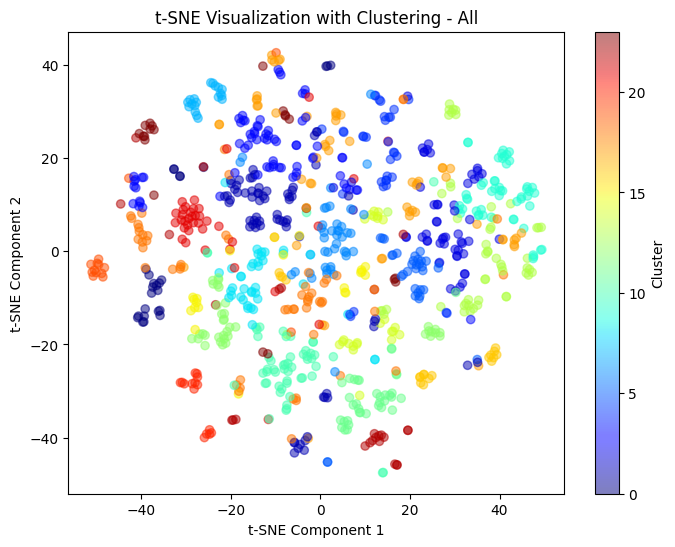

---------------------------Ads----------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Cluster 0
{'body care products', 'secret vanilla deodorant', 'shampoos', 'saltair shampoo and conditioner', 'secret clinical strength deodorant', 'method deodorant women', 'summer scent', 'anthropologie vanilla perfume', 'secret deodorant', 'body wash', 'body products', 'body hygiene products', 'intimate deodorant', 'deodorant for body odor', 'shower products', 'secret whole body deodorant', 'saltair serum deodorant', 'method body wash', 'saltair body wash', 'salicylic acid body wash', 'method body deodorant', 'body deodorant', 'eau de toilette vanille', 'vanille perfume', 'all over body deodorant', 'bath and shower product'}
Cluster 1
{'instax camera', 'instax printer', 'fuji film instax mini ', 'printer instax fujifilm', ' camera car', 'insta go ', 'instax - fujifilm', ' camera', 'insta  camera', 'instax mini', 'instax mini printer', 'instax', 'insta  go  camera', 'digital camera', 'insta', 'film camera', 'instant film effect'}
Cluster 2
{'purse', 'best diapers for baby recommendatio

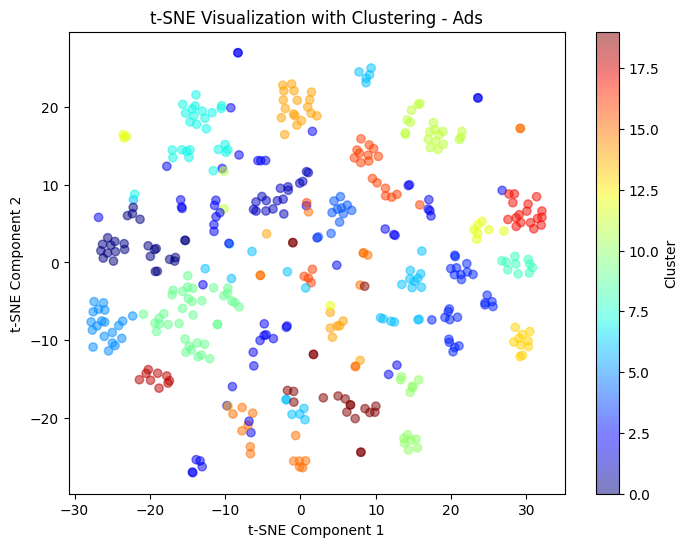

---------------------------Non-Ads----------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Cluster 0
{'pcos treatment', 'when is your luteal phase', 'cortisol fix', 'the luteal phase', 'when is the luteal phase', 'luteal phase', 'arguing phase in a relationship', 'follicular phase', 'cortisol', 'pcos beard', 'luteal phase bloating', 'maltreatment and pcos', 'period phases', 'hormone imbalance', 'cycle phases', 'cortisol imbalance', 'pcos symptom', 'luteal phase symptoms'}
Cluster 1
{'keke palmer singing', 'renee rapp', 'sza performing', 'keke palmer singing bend it over', 'alexandra trusova edits', 'anna ice skating', 'keke palmer singing bend it over original', 'mariah the scientist songs', 'keke palmer bend it over original', 'backflip ice skating', 'ms tatiana bend it over', 'singing bend it over', 'mariah the scientist performances', 'bend it over original', 'omahlay girl on stage', 'alexandra trusova', 'keke palmer bend it over', 'keke palmer', 'alexandra trusova crying'}
Cluster 2
{'cat food', 'can opener bottle opener', 'mexican food tiktok', "scrub daddy's shark tank

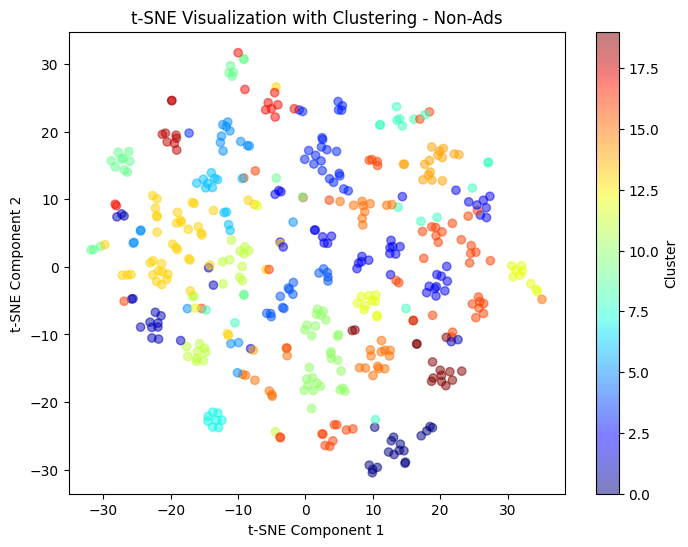

In [ ]:
getCluster(df1)

<ipython-input-101-8703ce520896>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Jaccard Similarity Score between Ads and Non-ads:  0.007159904534606206
---------------------------All----------------------------
Cluster 0
{'barrel racing', 'eurotrip', 'berlin germany', 'germany crowd sings country roads', 'cars', 'football athletes', 'germany aesthetic', 'race car sideways', 'germany electricity pole', 'super bowl', 'racing cars', 'living in germany', 'drag racing cars', 'racing', 'football clips', 'racing tiktok', 'germany', 'racing dirt track', 'football'}
Cluster 1
{'whitina girl song', 'powerpuff theme song', 'mitski screaming song', 'anime cosplay', 'whitina song', 'indie outfits', 'acting duets', 'victorious', 'celebrity duets', 'singing duets', 'whitina girl singing', 'song covers', 'new music to listen', 'fights school film', 'musical', 'film clips', 'victorious series', 'anime makeup', 'you are an americanized character in an anime reddit', 'indie kid ', 'cosplay convention', 'comedy theatre', 'anime tiktok', 'anime', 'mitski lyrics', 'mitski american sing

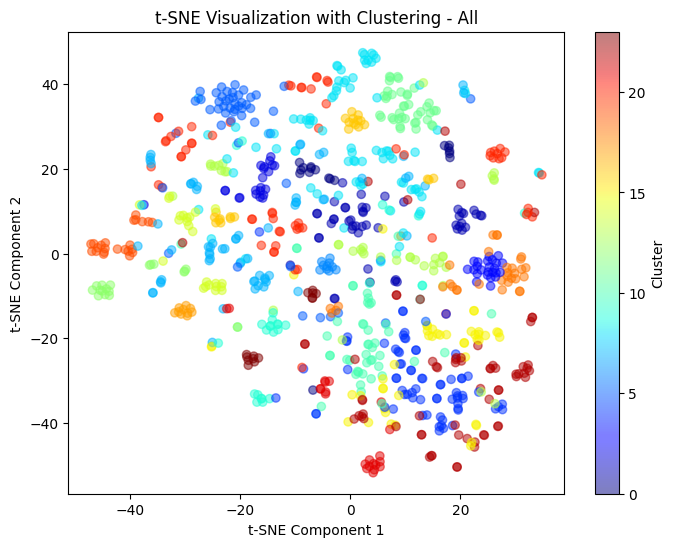

---------------------------Ads----------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Cluster 0
{'bike rider', 'temperature sensor', 'taxi driver', 'carpe for hands', 'door dasher driver', 'dasher driver', 'natural body moves', 'nurx birth control review', 'nurx', 'lifting platform', 'travel card', 'lifting belts', 'blast motion sensor', 'benson bus driver', 'medicube age r', 'birth control', 'timothee chalamet', 'food tiktok', 'training vest for soccer', 'cold feet', 'pet', 'bike riders movie', 'bus driver', 'training vest', 'driver swing', 'flower food', 'power lifting', '#coffeetiktok', 'halogen lights', 'training feet', 'doordasher delivery', 'carp fish', 'driver', 'nurx birth control', 'doordash food delivery', 'fits of the week', 'good time', 'nurx review', 'birth control pill', 'carpe au four', ' layers of white out', 'survival', 'life as a driver'}
Cluster 1
{'vitamin c skincare', 'uti remedies fast', 'probiotics', 'vitamin c serums', 'suja juice', 'uro probiotics for women', 'probiotic recommendation', 'best hydration packs', 'green juice', 'hydration condition

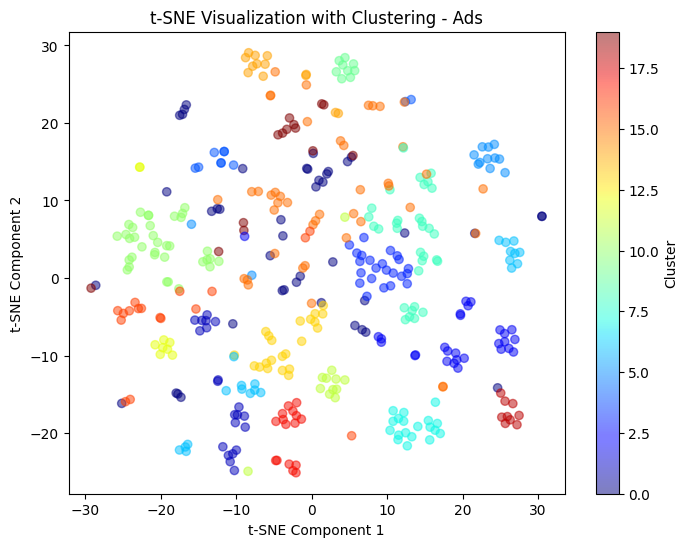

---------------------------Non-Ads----------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Cluster 0
{'ted lasso', 'mr gorsky neil armstrong', 'nancy and ted', 'austin butler dune ', 'ted movie', 'nate and ted lasso', 'elizabeth holmes voice', 'austin butler elvis presley', 'ted', 'boston tiktok', 'billy blanks ted cruz', 'boston city hall', 'darts scene ted lasso', 'ted lasso  series', 'bill and ted', 'austin butler dune voice', 'ted lasso ()', 'ted lasso edits', 'cruz swings at coach carter', 'and austin', 'austin moon', 'austin butler', 'boston city', 'boston', 'elizabeth holmes', 'better senator than ted cruz', 'ted tv show', 'aaron bushnell last words', 'austin butler voice'}
Cluster 1
{'blind', 'blind experiment', 'blind people', 'blind date reveal', 'how to change your mindset', ' stranger on blind date', 'blind girl', 'the green flag guy blind girl', 'blind blind date', 'what do blind people see'}
Cluster 2
{'zutara live action', 'avatar', "auli'i cravalho moana", 'cartman south park', 'badger moles avatar', "auli'i cravalho monana live action", 'zuko', 'avatar last 

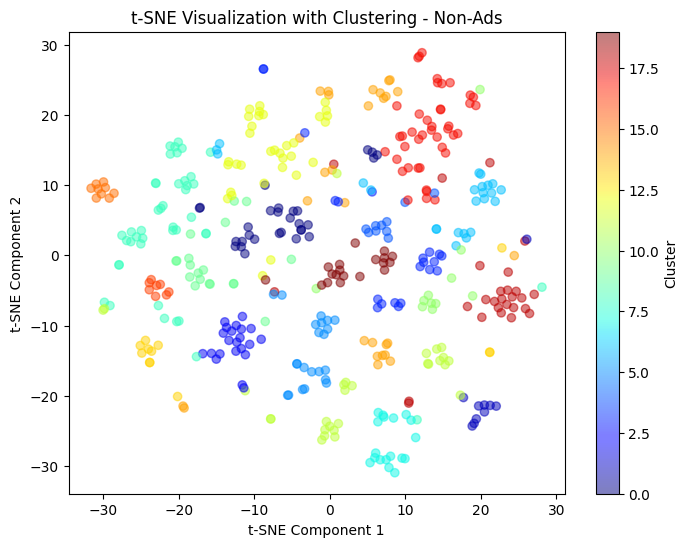

In [ ]:
getCluster(df2)

<ipython-input-101-8703ce520896>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Jaccard Similarity Score between Ads and Non-ads:  0.003579952267303103
---------------------------All----------------------------
Cluster 0
{'nails art', 'nail', 'nails before and after transition', 'me without nails vs me with nails', 'valentines nails', 'nail videos', 'nails', 'clear coat on car', 'me without nails', 'me with nails vs me without them', 'nail inspo', 'nail company', 'nail filter', 'nails of tiktok', 'me without nails trend', 'nail salon comedy', 'nail salon acrylics'}
Cluster 1
{'laro benz ex girlfriend', 'chelsea', 'austin mcbroom skeeyee', 'laro benz little sister', 'chelsea team mom', 'yeah - usher', 'austin pranks kenny in car', 'island boyrah car salesman', 'realtors on tiktok', 'how old is nina', 'austin mcbroom basketball', 'vontek gets his hellcat back', 'ariana', 'usher glitch dance on super bowl', 'maci bookout edits', 'cold world eric reprid', 'commas by ayra starr', 'laro benz', 'fastest mathematician', 'saint pablo', 'eric reprid', 'austin mcbroom edits'

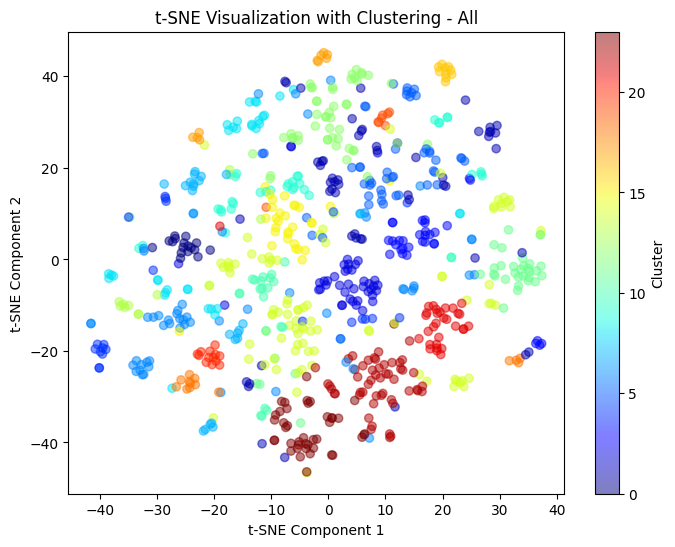

---------------------------Ads----------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Cluster 0
{'babybel cheese', 'tiktok snacks', 'no nacho cheese', 'nachos with doritos', 'soggy cereal', 'pretzel', 'nacho', 'doritos no nacho cheese', 'food tiktok', 'doritos', 'todoroni and cheese', 'snacks', 'mini food', 'miniverse make it mini food', 'frosted flakes', 'sweet snacks', 'food recipes', 'sweet snack ideas', 'making cheese', 'holiday snacks', 'doritos minis', 'doritos tacos in a bag', 'snack ideas', 'dorito nachos'}
Cluster 1
{'#happybirthday', 'tonytalks', 'davido', 'skintok', 'organic cotton', 'muselyreviews', 'jimmy', 'hbcu life', 'cotton', 'aeriannasingss', 'apartment', 'howard university', 'footballtiktok', 'hbcu', 'unbrush', 'the unbrush', 'saltair', 'dr', 'clearstem', 'wigfever', 'howard university lil zeddy', 'aerianna hubbard', 'greenface', 'just like dat', 'howard university anok yai', 'burnaboyofficial', 'whats greenface', 'cheesetok', 'brands', 'flyanaboss', 'unbrush honest review', 'biracial', 'unbrush review'}
Cluster 2
{'yellow teeth', 'period care', 'cres

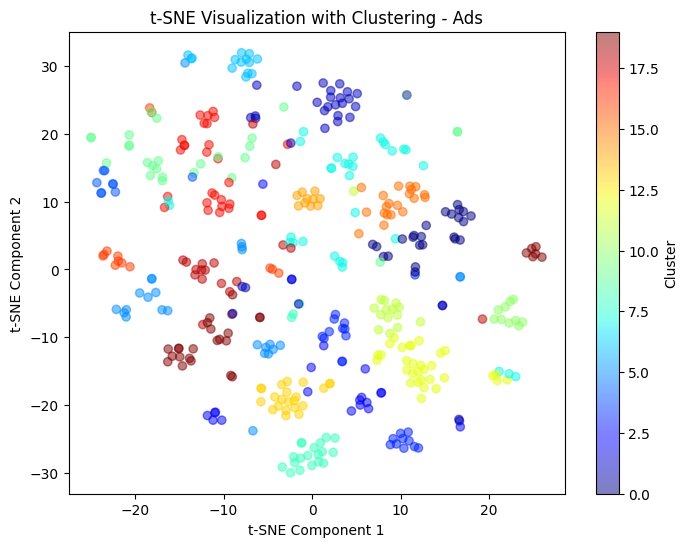

---------------------------Non-Ads----------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Cluster 0
{'cardi b in high school yearbook', 'cardi b speaking spanish', 'tems wait for u', 'cardi b kiss a woman', 'jk bts', 'cardi b in middle school', 'cardi b funny moment', 'jimin', 'tems i will wait for you', 'tae and jin bts', 'bts jungkook', 'bts jimin', 'bts - suga', 'offset and cardi b', 'tems kith x bose', 'bibi kpop idol', 'cardi b in high school', 'cardi b', 'kpop idols', 'cardi b bisexual', 'cardi b young'}
Cluster 1
{'croissants', 'tres leches cake', 'mini stair stepper', 'sugar rush bibi yena soyeon', 'baby rolling cart', 'tres leches crumbl cookies', 'cookie new jeans', 'washing fruit', 'croissant toast', 'tres leches cake crumbl', 'cleaning fruits', 'baby toothbrush', 'crumbl tres leches', 'baby in the kitchen', 'baby food ideas', 'raymonte dumplings', 'baby stuff', 'wear the spoon', 'croissant desserts', 'popsicles', 'baby dancer', 'fruit juicing', ' leches cake', 'cookies', 'doorbell camera', 'microwaving fruit allergies', 'tres leches', 'baby pushing bottle', 'fru

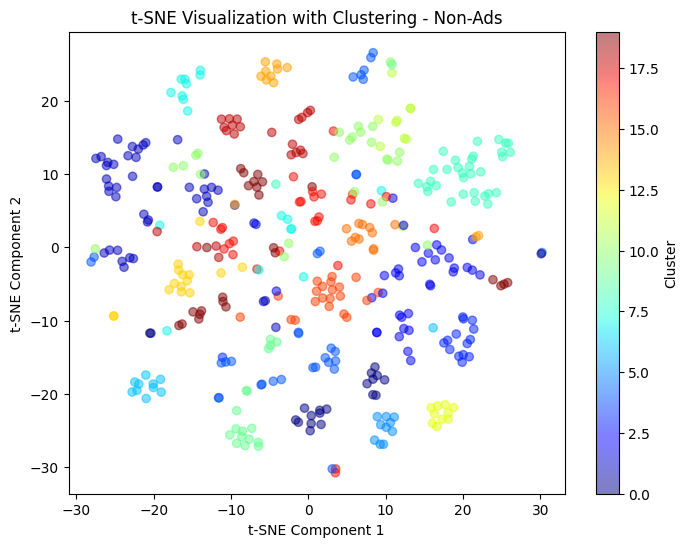

In [ ]:
getCluster(df3)

<ipython-input-101-8703ce520896>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Jaccard Similarity Score between Ads and Non-ads:  0.0036188178528347406
---------------------------All----------------------------
Cluster 0
{'jeffreestarcosmetics', 'cottagecore', 'berleezy', 'booktok', 'fox', 'scream ', 'alpha', 'bill', 'island life', 'x files', 'wordle', 'divorce', 'king', 'darling', 'barstoolsports', 'the royalty family', 'vintage', 'chaser', 'birdy', 'body treatments', 'crave', 'poet', 'soldier', 'modern family', 'doppelgänger', 'zella', 'britscookin', 'femininity', 'situationship', 'history', 'michealjacksoninnocent', 'courteneycoxofficial', 'guatemala', 'isa\U0001fa77', 'citizen', 'lemon', 'carringtonxx', "'s rock", 'babybushwhacked', 'history tiktok', 'influencer', 'adelaide', 'nantucket', 'french speaking', 'do not come', 'crawlingcrab', 'nataliebiden', 's home', 'dollypartonwannabe', 'frownies', 'nature', 'phantom', 'bodies', 'we are the world', 'come', 'amine', 'royalty family', 'anti semiticism', 'suns', 'bollywood', 'wyll', 'we are the world ', 'lawyer', 

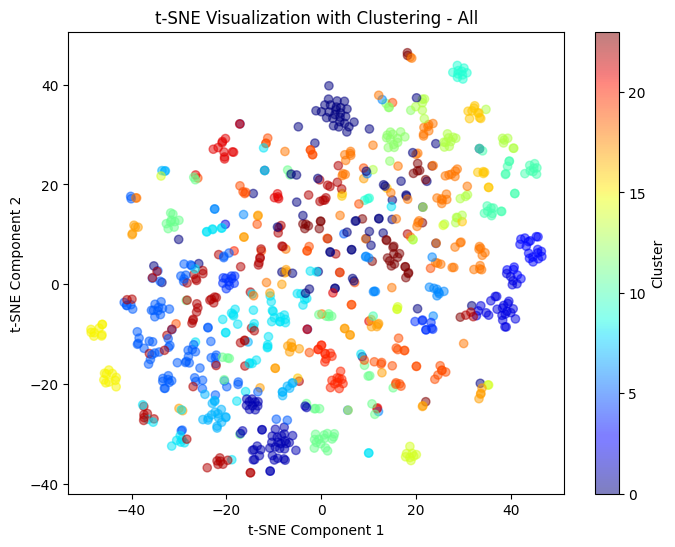

---------------------------Ads----------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Cluster 0
{'how to clean pierced ear', 'olay skincare', 'retinol every night', 'get ready with me makeup video', 'night routine', 'retinol moisturizer', 'night time skincare routine', 'makeup', 'how to clean nose piercing', 'makeup covergirl', 'nose piercing jewelry', 's makeup', 'concealer lips', 'ear pierced inspo', 'tea tree oil', 'makeup tutorial', 'covergirl skin milk foundation', 'dream matte mousse', 'essence cosmetics', 'ear piercing', 'get ready with me cosmetics', 'ootd inspo', 'makeup in the s', 'covergirl concealer', 'skin care with retinol', 'routine skincare', 'retinol recommendation', 'covergirl bb cream', 'retinol lotion', 'piercing jewelry', 'retinol facial', 'olay body wash', 'night time skin routine', 'relaxing night routine', 'get ready with me makeup', 'night time routine', 'retinol serums recommendations', 'clothing inspo', 'retinol serum', 'retinol'}
Cluster 1
{'crock pot marry me chicken', 'honey mustard chicken', 'marry me chicken recipes', 'marry me chicken', 

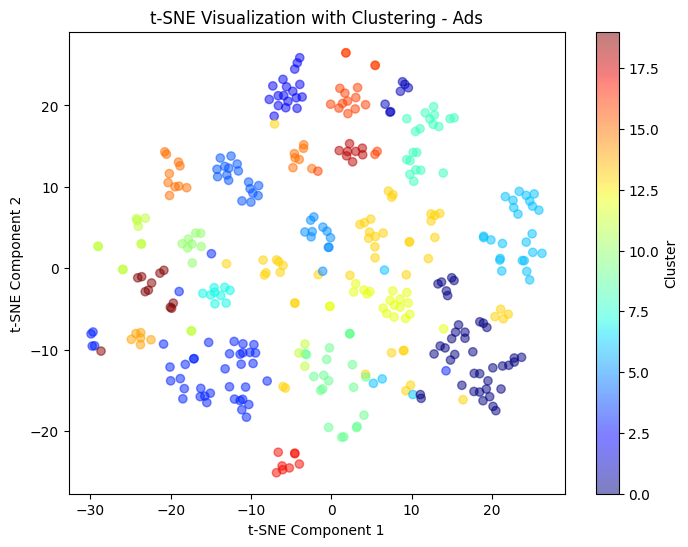

---------------------------Non-Ads----------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Cluster 0
{'now watch this drive'}
Cluster 1
{'broadway theatre', 'broadway', 'elmo', 'elmo balsamic vinaigrette', 'musical', "see i'm smiling", 'gabbie hanna house guy', 'margot robbie singing closer to fine', 'chloe troast singing', 'broadway musical theatre', 'elmo nyc accent', 'gabbie hanna singing', 'gabbie hanna ymca video', 'elmo new york accent', 'elmo savage moments', 'elmo saying balsamic vinegar', 'broadway musicals', 'elmo voice actor', 'how am i supposed to react to gabbie hanna', 'broadway tiktok', 'performing on broadway', 'elmo funniest moments', 'gabbie hanna singing in mic', 'musical theatre', 'gabbie hanna manic', 'dong sicheng edits', 'elmo rocco', 'margot robbie singing', 'elmo balsamicvinegar'}
Cluster 2
{'united kingdom', 'different uk accents', 'england', 'england tiktok', 'uk accents', 'scotland', 'edinburgh scotland', 'your english is so good', 'england weather', 'british boro accent', 'uk life', 'uk beauty', 'uk', 'in the uk', 'british accents', 'uk tiktok', 

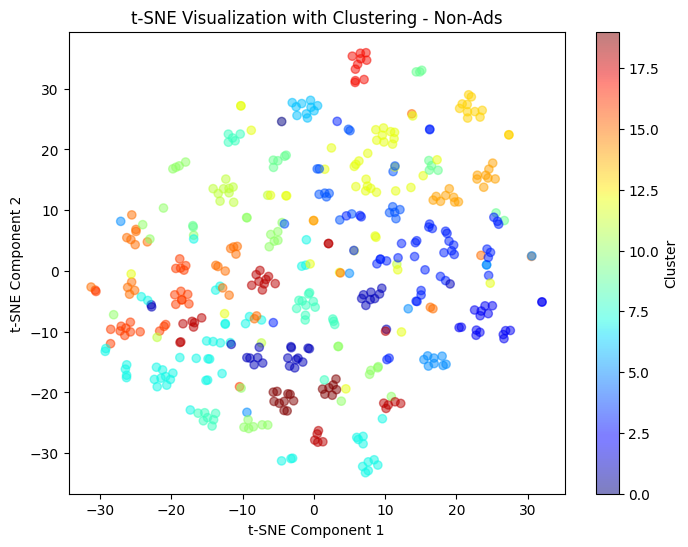

In [ ]:
getCluster(df4)

<ipython-input-101-8703ce520896>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Jaccard Similarity Score between Ads and Non-ads:  0.011689691817215728
---------------------------All----------------------------
Cluster 0
{'alex poulx tyler funke', 'sophie jones alex poulx apartment', 'alix earle princess polly shirt', 'steve lacy songs', 'sophie jones apartment', 'brooke monk pick me', 'claudia', 'alix earle princess polly white top', 'brooke monk makeup tutorial', 'is this too much for a bar alix earle', 'jasper and alice', 'brooke monk being a pick me', 'dark red steve lacy', 'brooke monk', 'alix earl bar in new jersey top', 'alix earl white top', 'alex earl princess polly top', 'brooke monk body', 'gordon ramsay reacts to zach choi', 'olivia newton john', 'princess polly white top alix', 'brooke monk white icing melon', 'steve lacy', 'sophie jones', 'bad habit steve lacy', 'brooke monk best pictures', 'is this top too much alix earle', 'brooke monk no makeup', 'dylan jordan', 'alex poulx and lucas', 'brooke monk feet', 'alex poulx apartment'}
Cluster 1
{'chamoy

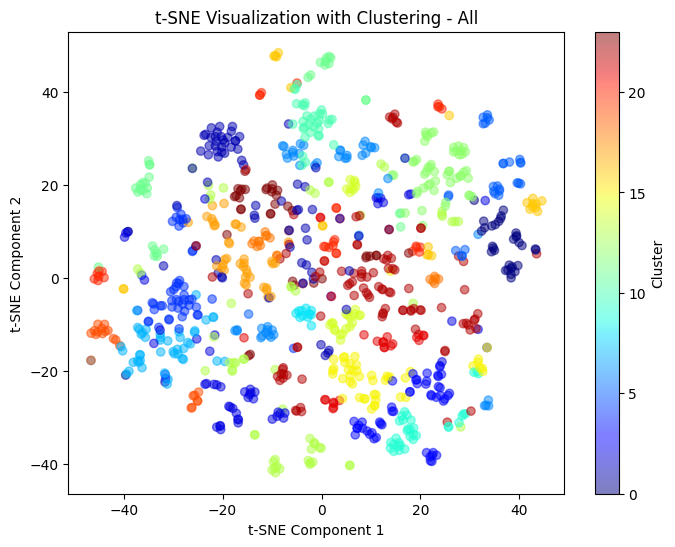

---------------------------Ads----------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Cluster 0
{'chamoy pickle kit', 'sweatshirts', 'halara waffle pants', 'pickle shirt', 'hanes', 'tiktok shop sweatshirt', 'cute crewneck sweatshirts', 'hanes sweatpants', 'halara high waisted pants', 'pickle hoodie', 'pickle jar sweatshirt', 'pickle sweatshirt', 'halara work pants', 'crewneck sweatshirt', 'pickle', 'halara pants'}
Cluster 1
{'infallible blush', 'telescope mascara', 'dior blush', 'loreal infallible blush', 'blush and glow', 'makeup', 'sky high mascara', 'ilia mascara', 'blush', 'mascara tutorial', 'pixie blush stick', 'joanne lee makeup', 'bottom lash mascara', 'makeup tutorial', 'mascara combo', 'spencer makeup artist', 'stick blush', 'fake makeup asmr', 'pretend makeup', 'blush pixi', 'fake makeup kit kids', 'rare beauty mascara', 'loreal paris blush', 'best drugstore mascara ', 'pretend make up kit', 'blush recommendation', 'infallible fresh wear blush', 'on-the-glow pixi blush', 'lancome primer mascara', 'dior pink blush', 'blush makeup', 'loreal blush', 'on the glow

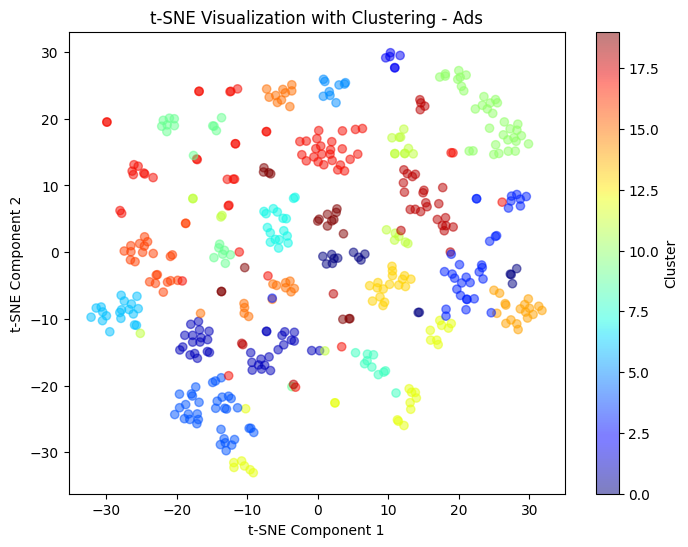

---------------------------Non-Ads----------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Cluster 0
{'lash mascara', 'mascara', 'what kind of mascara do you use?', 'green leaf mascara', 'mascara makeup', 'lash next door mascara review', 'pinky toenail', 'lash next door mascara', 'small pinky toenail', 'brown mascara', 'natural mascara', 'mascara long lashes', 'tiny pinky toenail'}
Cluster 1
{'paranormal activity', 'bisan before', 'scary movies', 'pixel filter effects', 'scary tiktok', 'pixel filter', 'blight survival', 'milk under bed', 'spoiled milk', 'fatima arias teeth before braces', 'labour and delivery', 'milk gone bad', 'toilet paper roll', 'put down a finger story', 'blight', 'putting milk under bed', 'entitled worker called me a child story', 'fragment footnicki', 'blight survival release date', 'wizard bisan', 'labor and delivery nurse', 'cup of milk under the bed meaning', 'pixelated filter', 'rotten milk', 'blight gameplay', 'drowning in ball pit', 'blight survival gameplay', 'natural labor', 'blight game', 'toilet paper public bathroom', 'putting milk under bed

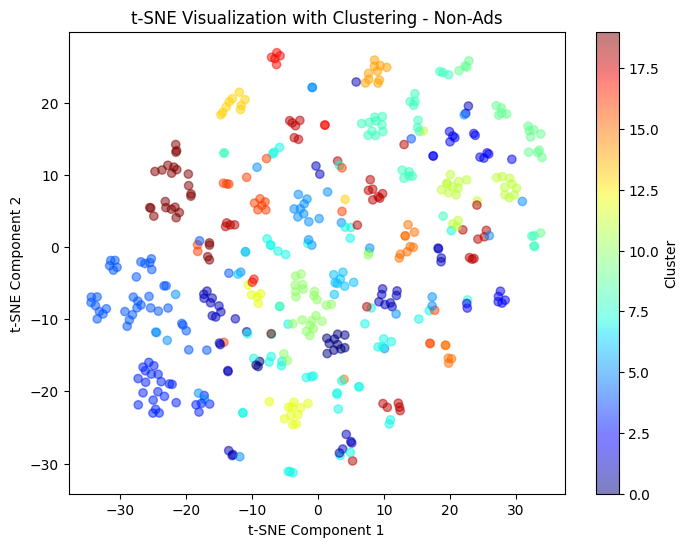

In [ ]:
getCluster(df5)

In [ ]:
#TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tfidfVectorizer = TfidfVectorizer()
X = tfidfVectorizer.fit_transform(suggested)
df = pd.DataFrame(X.toarray(), columns = tfidfVectorizer.get_feature_names_out())
df

In [ ]:
k = 24
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(df)

In [ ]:
all_clusters = []
for i in range(k):
  print(f"Cluser {i}")
  cluster_words = {suggested[j] for j in range(len(suggested)) if clusters[j] == i}
  all_clusters.append(cluster_words)
  print(cluster_words)